In [267]:
from yako_util import util as q
from yako_util import era5 as era5
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn.metrics as metrics
import sklearn
from metpy.calc import mixing_ratio_from_specific_humidity, density
from metpy.units import units
from metpy.constants import g
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

## Load dataset

In [ ]:
files = sorted(q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase/2014/'))

tc_gmi_files = sorted(list(filter(lambda x: 'gmi_tc' in x, files)))
tc_sim_scatt_files = sorted(list(filter(lambda x: 'Tc_hydro_13ch' in x, files)))
tc_sim_clear_files = sorted(list(filter(lambda x: 'Tc_clear_13ch' in x, files)))

specific_humidity_files = sorted(list(filter(lambda x: 'era5_specific_humidity' in x, files)))
temperature_files = sorted(list(filter(lambda x: 'era5_temperature' in x, files)))
surface_pressure_files = sorted(list(filter(lambda x: 'surface_pressure' in x, files)))
tm_temperature_files = sorted(list(filter(lambda x: 'era5_2m_temperature' in x, files)))
tm_dewpoint_temperature_files = sorted(list(filter(lambda x: 'era5_2m_dewpoint_temperature' in x, files)))
skin_temperature_files = sorted(list(filter(lambda x: 'era5_skin_temperature' in x, files)))

cloud_liquid_water_files = sorted(list(filter(lambda x: 'era5_cloud_liqud_water' in x, files)))
cloud_ice_water_files = sorted(list(filter(lambda x: 'era5_cloud_ice_water' in x, files)))
precip_liquid_water_files = sorted(list(filter(lambda x: 'era5_precip_liquid_water' in x, files)))
precip_ice_water_files = sorted(list(filter(lambda x: 'era5_precip_ice_water' in x, files)))

landsea_telsem_files = sorted(list(filter(lambda x: 'landsea_telsem' in x, files)))

es_files = sorted(list(filter(lambda x: 'es_telsem_13ch' in x, files)))

lat_files = sorted(list(filter(lambda x: 'gmi_lat' in x, files)))
lon_files = sorted(list(filter(lambda x: 'gmi_lon' in x, files)))

autosnow_files = sorted(list(filter(lambda x: 'autosnow' in x, files)))

In [187]:
tc_gmi = np.concatenate(list(map(np.load, tc_gmi_files)), axis=0)
tc_sim_scatt = np.concatenate(list(map(np.load, tc_sim_scatt_files)), axis=0)
tc_sim_clear = np.concatenate(list(map(np.load, tc_sim_clear_files)), axis=0)

lat = np.concatenate(list(map(np.load, lat_files)), axis=0)
lon = np.concatenate(list(map(np.load, lon_files)), axis=0)

pressure = np.tile(era5.get_pressure_levels()[::-1], (tc_gmi.shape[0], 1))
nprofiles = pressure.shape[0]
nlevels = pressure.shape[1]

surface_pressure = np.concatenate(list(map(np.load, surface_pressure_files)), axis=0).reshape(nprofiles)
tm_temperature = np.concatenate(list(map(np.load, tm_temperature_files)), axis=0).reshape(nprofiles)
tm_dewpoint_temperature = np.concatenate(list(map(np.load, tm_dewpoint_temperature_files)), axis=0).reshape(nprofiles)
skin_temperature = np.concatenate(list(map(np.load, skin_temperature_files)), axis=0).reshape(nprofiles)
autosnow = np.concatenate(list(map(np.load, autosnow_files)), axis=0).reshape(nprofiles)

specific_humidity = np.concatenate(list(map(np.load, specific_humidity_files)), axis=0).reshape(nprofiles, nlevels)
temperature = np.concatenate(list(map(np.load, temperature_files)), axis=0).reshape(nprofiles, nlevels)
cloud_liquid_water = np.concatenate(list(map(np.load, cloud_liquid_water_files)), axis=0).reshape(nprofiles, nlevels)
cloud_ice_water = np.concatenate(list(map(np.load, cloud_ice_water_files)), axis=0).reshape(nprofiles, nlevels)
precip_liquid_water = np.concatenate(list(map(np.load, precip_liquid_water_files)), axis=0).reshape(nprofiles, nlevels)
precip_ice_water = np.concatenate(list(map(np.load, precip_ice_water_files)), axis=0).reshape(nprofiles, nlevels)

es = np.concatenate(list(map(np.load, es_files)), axis=0).reshape(nprofiles, 13)
landsea_telsem = np.concatenate(list(map(np.load, landsea_telsem_files)), axis=0).reshape(nprofiles)

In [189]:
mixing_ratio = mixing_ratio_from_specific_humidity(specific_humidity * units('kg/kg')).to('g/kg')
moist_air_density = density(pressure * units.hPa, temperature * units.K, mixing_ratio).to('kg/m3')

qr_avg = (precip_liquid_water[:,:-1] + precip_liquid_water[:,1:]) / 2
qi_avg = (precip_ice_water[:,:-1] + precip_ice_water[:,1:]) / 2
qc_avg = (cloud_liquid_water[:,:-1] + cloud_liquid_water[:,1:]) / 2
qci_avg = (cloud_ice_water[:,:-1] + cloud_ice_water[:,1:]) / 2

dp = -np.diff((pressure*units.hPa).to(units.Pa), axis=1)
tcwv = np.sum(((qr_avg + qi_avg + qc_avg + qci_avg) * dp) / g, axis=1).to('kg/m2').m

0 - water only \
1 - land only \
2 - snow land only \
3 - ice only \
4 - frozen sea (ice and water) \
5 - beach (land and water) \
6 - frozen beach (snow/land and water/ice) \
7 - glacier (snow/land and ice)

In [190]:
valid_mask = (
    np.all(tc_gmi >= 50, axis=1) &
    np.all(tc_gmi <= 500, axis=1) &
    np.all(tc_sim_scatt >= 50, axis=1) &
    np.all(tc_sim_scatt <= 500, axis=1) &
    np.all(tc_sim_clear >= 50, axis=1) &
    np.all(tc_sim_clear <= 500, axis=1)
)

telsem_surf = landsea_telsem == 1
telsem_water = landsea_telsem == 0

sea_mask = autosnow == 0
land_mask = autosnow == 1
snow_mask = autosnow == 2
ice_mask = autosnow == 3
frozen_sea_mask = autosnow == 4
beach_mask = (autosnow == 5) | (autosnow == 6)
glacier_mask = autosnow == 7

clear_sky_mask = tcwv <= 0.015

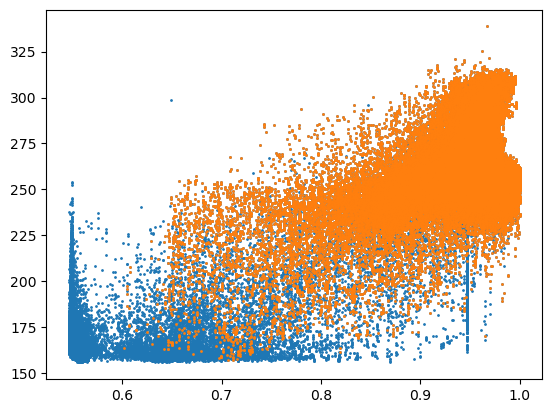

In [191]:
plt.scatter(es[valid_mask,0], tc_gmi[valid_mask,0], s=1)
plt.scatter(es[valid_mask&(land_mask|snow_mask|ice_mask)&telsem_surf,0], tc_gmi[valid_mask&(land_mask|snow_mask|ice_mask)&telsem_surf,0], s=1)
# plt.scatter(es[valid_mask&telsem_surf,0], tc_gmi[valid_mask&telsem_surf,0], s=1)
# plt.scatter(es[valid_mask&telsem_water,0], tc_gmi[valid_mask&telsem_water,0], s=1)

In [192]:
channels = q.gmi_channels()

# Direct models

In [275]:
features = np.array([
    tcwv,
    surface_pressure,
    tm_dewpoint_temperature,
    tm_temperature,
    skin_temperature,
    autosnow,
]).T

labels = es

split = 0.7

In [276]:
train_mask = np.array([True]*int(len(features)*split) + [False]*(len(features) - int(len(features)*split)))
test_mask = ~train_mask

use_data_mask = valid_mask&(land_mask|snow_mask|ice_mask)&telsem_surf
train_mask = train_mask & use_data_mask
test_mask = test_mask & use_data_mask

use_clear_sky_mask = clear_sky_mask[use_data_mask]

## Poly model

In [277]:
poly_features = PolynomialFeatures(degree=1)
X_train = poly_features.fit_transform(features[train_mask])
X_test = poly_features.transform(features[test_mask])
X = poly_features.transform(features[use_data_mask])

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [278]:
lin_reg = MultiOutputRegressor(LinearRegression())
lin_reg.fit(X_train, Y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [279]:
P_train = np.clip(lin_reg.predict(X_train), 0, 1)
P_test = np.clip(lin_reg.predict(X_test), 0, 1)
P = np.clip(lin_reg.predict(X), 0, 1)

In [280]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.03339127 0.06043711 0.03339127 0.06043711 0.03185504 0.03236927
 0.05477284 0.03130374 0.04753311 0.03051967 0.04125559 0.03060809
 0.03060809]
[0.05301681 0.07862604 0.05301681 0.07862604 0.05058063 0.04792056
 0.06601565 0.0468617  0.05481427 0.04669957 0.04958382 0.04684295
 0.04684295]
[0.03773432 0.07822132 0.03773432 0.07822132 0.03590385 0.03662081
 0.06883906 0.03564824 0.05763564 0.0345513  0.04886966 0.03463782
 0.03463782]
[0.05733809 0.10008291 0.05733809 0.10008291 0.05467314 0.0516855
 0.0818934  0.05468414 0.06832221 0.05436792 0.06060187 0.05452814
 0.05452814]


Text(0.5, 0.98, 'MAE')

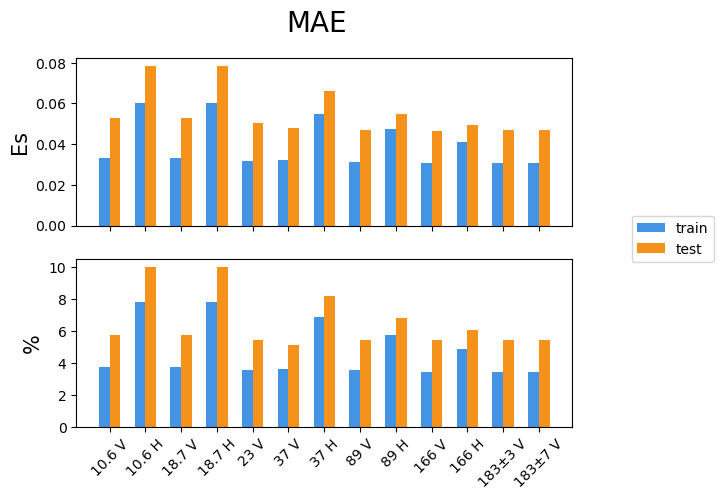

In [281]:
_x = np.array(list(range(13)))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels, rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE', fontsize=20)

In [282]:
_lin_p_test = P_test

## GBRT model

In [283]:
X_train = features[train_mask]
X_test = features[test_mask]
X = features[use_data_mask]

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [284]:
gbrt_reg = MultiOutputRegressor(HistGradientBoostingRegressor())
gbrt_reg.fit(X_train, Y_train)

MultiOutputRegressor(estimator=HistGradientBoostingRegressor())

In [285]:
P_train = np.clip(gbrt_reg.predict(X_train), 0, 1)
P_test = np.clip(gbrt_reg.predict(X_test), 0, 1)
P = np.clip(gbrt_reg.predict(X), 0, 1)

In [286]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.02112597 0.03698662 0.02121933 0.03687234 0.02047087 0.01966177
 0.03392777 0.01697325 0.02949364 0.01547002 0.02548071 0.01552773
 0.01553307]
[0.05373537 0.08350015 0.05302048 0.0839907  0.05281504 0.05637897
 0.07742966 0.04328352 0.05294709 0.04404786 0.04654649 0.04418441
 0.04350003]
[0.02362721 0.04673062 0.02372584 0.04651499 0.0228689  0.02213126
 0.04211329 0.01909112 0.03549624 0.01727183 0.02991333 0.01732426
 0.01733034]
[0.05727127 0.10113084 0.05656438 0.10158761 0.05639894 0.06071555
 0.09276416 0.04979105 0.06403173 0.05067203 0.05541162 0.05092394
 0.05008945]


Text(0.5, 0.98, 'MAE')

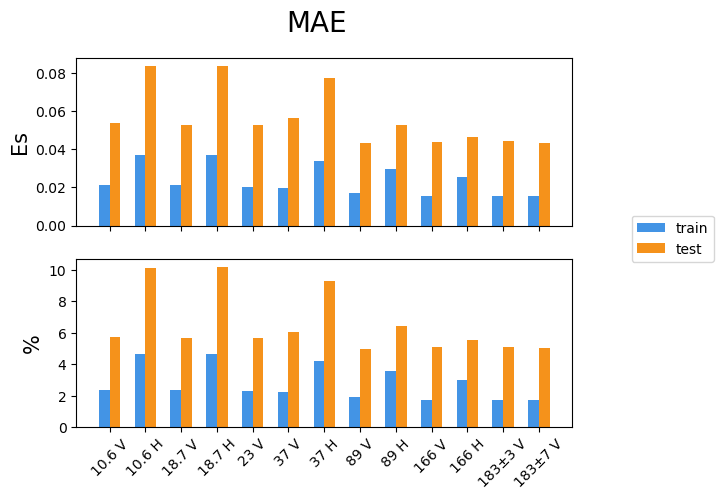

In [287]:
_x = np.array(list(range(13)))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels, rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE', fontsize=20)

In [289]:
P_test - _lin_p_test

array([[-0.01216203, -0.01862991, -0.00801959, ...,  0.00604189,
         0.01067048,  0.00945031],
       [-0.01216203, -0.01862992, -0.00801959, ...,  0.00604189,
         0.01067049,  0.00945032],
       [-0.01216203, -0.01862992, -0.00801959, ...,  0.00604189,
         0.01067049,  0.00945032],
       ...,
       [-0.04634317, -0.09208082, -0.04539987, ..., -0.0576866 ,
        -0.00791269, -0.00349023],
       [-0.05368182, -0.09197423, -0.04596135, ..., -0.05680058,
        -0.01068208, -0.00187748],
       [-0.05368182, -0.09197423, -0.04596135, ..., -0.05680058,
        -0.01068207, -0.00187748]])